In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import wrf
import datetime as dt

In [2]:
def preprocess(f):
    
    time_strs = [str(i.values)[1:].replace("_"," ") for i in f.Times]
    time_datetime = pd.to_datetime(time_strs)
    f = f.assign(Time=time_datetime)
    
    return f
    
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)    
    
def get_wrf_points(f,wrflist,ship_lons,ship_lats,d=75):
    ship_x, ship_y = wrf.ll_to_xy(wrflist,ship_lats,ship_lons).values
    target_x = xr.DataArray(ship_x,dims="points")
    target_y = xr.DataArray(ship_y,dims="points")
    ws_points = f.sel(south_north=target_y, west_east=target_x).ws.values
    wrf_lats = f["XLAT"].isel(Time=0).values
    wrf_lons = f["XLONG"].isel(Time=0).values
    dist = np.stack([latlon_dist(ship_lats[i], ship_lons[i], wrf_lats, wrf_lons) for i in tqdm.tqdm(range(len(ship_lats)))])
    ws_mask = f["ws"].where(dist<=d,np.nan).max(("south_north","west_east")).persist()
    return ws_mask

def underway_hourly_rain_to_accumulation(da_rain):

    diff = da_rain.diff("time",1)
    return diff.where(diff > 0, 0).cumsum()

In [3]:
files = np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/sfcwind_d04_2023-10-*"))
dates = [dt.datetime.strptime(f.split("/")[-1][12:],"%Y-%m-%d_%H:%M:%S") for f in files]
f = xr.open_mfdataset(files[(np.array(dates)>=dt.datetime(2023,10,16,0,30,0)) & (np.array(dates)<=dt.datetime(2023,10,16,6,30))],
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
f["ws"] = np.sqrt(np.square(f["U10"]) + np.square(f["V10"]))
times = f.Time.values
wrflist = Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/sfcwind_d04_2023-10-15_15:00:00")

0.3.0


In [4]:
files = np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/sfcwind_d04_2023-10-*"))
dates = [dt.datetime.strptime(f.split("/")[-1][12:],"%Y-%m-%d_%H:%M:%S") for f in files]
f_3Kplus = xr.open_mfdataset(files[(np.array(dates)>=dt.datetime(2023,10,16,0,30,0)) & (np.array(dates)<=dt.datetime(2023,10,16,6,30))],
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
f_3Kplus["ws"] = np.sqrt(np.square(f_3Kplus["U10"]) + np.square(f_3Kplus["V10"]))
wrflist_3Kplus = Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/sfcwind_d04_2023-10-15_15:00:00")

In [5]:
files = np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/sfcwind_d04_2023-10-*"))
dates = [dt.datetime.strptime(f.split("/")[-1][12:],"%Y-%m-%d_%H:%M:%S") for f in files]
f_3Kminus = xr.open_mfdataset(files[(np.array(dates)>=dt.datetime(2023,10,16,0,30,0)) & (np.array(dates)<=dt.datetime(2023,10,16,6,30))],
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
f_3Kminus["ws"] = np.sqrt(np.square(f_3Kminus["U10"]) + np.square(f_3Kminus["V10"]))
wrflist_3Kminus = Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/sfcwind_d04_2023-10-15_15:00:00")

In [6]:
t1 = "2023-10-16 00:30"
t2 = "2023-10-16 06:30"
fname_met = ["/g/data/w40/ab4502/IN2023_V06/data/underway/20231015-213339-metstation-met_01.met"]
fname_weather = ["/g/data/w40/ab4502/IN2023_V06/data/underway/20231015-213339-weather-met_01.met"]
fname_nav = ["/g/data/w40/ab4502/IN2023_V06/data/underway/20231015-213338-shipnav-shipnav_01.nav"]
ds_met = xr.concat([xr.open_dataset(f) for f in fname_met],"time").sel(time=slice(t1,t2))
ds_weather = xr.concat([xr.open_dataset(f) for f in fname_weather],"time").sel(time=slice(t1,t2))
ds_nav = xr.concat([xr.open_dataset(f) for f in fname_nav],"time").sel(time=slice(t1,t2))[["lat","long"]]

da_windspeed = ds_weather.anemtruewindspeed.sel(time=times,method="nearest") / 1.944
da_winddir = ds_weather.anemtruewinddir.sel(time=times,method="nearest")
da_airpressure = ds_weather.airpressure.sel(time=times,method="nearest")
da_dewpt = ds_weather.dewpt.sel(time=times,method="nearest")
da_airtemp = ds_weather.airtemp.sel(time=times,method="nearest")
da_rain = (underway_hourly_rain_to_accumulation(ds_weather.starboardcumulativehourrain) + \
           underway_hourly_rain_to_accumulation(ds_weather.portcumulativehourrain)) / 2


In [7]:
print("Mean reporting frequency",ds_weather.time.diff("time").dt.total_seconds().mean().values,"seconds")
print("One min inst. max",(ds_weather.anemtruewindspeed.sel(time=times,method="nearest") / 1.944).max().values,"m/s")
print("Max",(ds_weather.anemtruewindspeed.sel(time=slice(times.min(),times.max())) / 1.944).max().values,"m/s")
print("Max to 4-hour mean ratio",
      (ds_weather.anemtruewindspeed.sel(time=slice(times.min(),times.max())) / 1.944).max().values / 
          (ds_weather.anemtruewindspeed.sel(time=slice("2023-10-16 01:30","2023-10-16 05:30")) / 1.944).mean().values,
      "m/s")

Mean reporting frequency 4.536344767651446 seconds
One min inst. max 27.880659103393555 m/s
Max 30.617284774780273 m/s
Max to 4-hour mean ratio 3.0204965745272934 m/s


In [8]:
#THREE OPTIONS FOR PLOTTING WRF WIND SPEED

#First, a neighbourhood max around ship location
# ship_lons = []
# ship_lats = []
# for t in tqdm.tqdm(range(times.shape[0])):
#     current_nav = ds_nav.sel(time=times[t],method="nearest")
#     ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
#     ship_lats.append(float(ship_lat))
#     ship_lons.append(float(ship_lon))

# wrf_ws = get_wrf_points(f,wrflist,ship_lons,ship_lats)
# wrf_3Kplus_ws = get_wrf_points(f_3Kplus,wrflist_3Kplus,ship_lons,ship_lats)

#Or, a static point location
static_lon = ds_nav.sel(time="2023-10-16 03:35:00").long.values[0]
static_lat = -36.5
x,y = wrf.ll_to_xy(wrflist,static_lat,static_lon).values
wrf_ws = f.ws.sel(south_north=y,west_east=x)
x,y = wrf.ll_to_xy(wrflist_3Kplus,static_lat,static_lon).values
wrf_3Kplus_ws = f_3Kplus.ws.sel(south_north=y,west_east=x)
x,y = wrf.ll_to_xy(wrflist_3Kminus,static_lat,static_lon).values
wrf_3Kminus_ws = f_3Kminus.ws.sel(south_north=y,west_east=x)

#Or, static point with neighbourhood max
# static_lon = ds_nav.sel(time="2023-10-16 03:35:00").long.values[0]
# static_lat = -36.5
# ship_lons = []
# ship_lats = []
# for t in tqdm.tqdm(range(times.shape[0])):
#     ship_lats.append(static_lat)
#     ship_lons.append(static_lon)
# wrf_ws = get_wrf_points(f,wrflist,ship_lons,ship_lats,d=25)
# wrf_3Kplus_ws = get_wrf_points(f_3Kplus,wrflist_3Kplus,ship_lons,ship_lats,d=25)
# wrf_3Kminus_ws = get_wrf_points(f_3Kminus,wrflist_3Kminus,ship_lons,ship_lats,d=25)


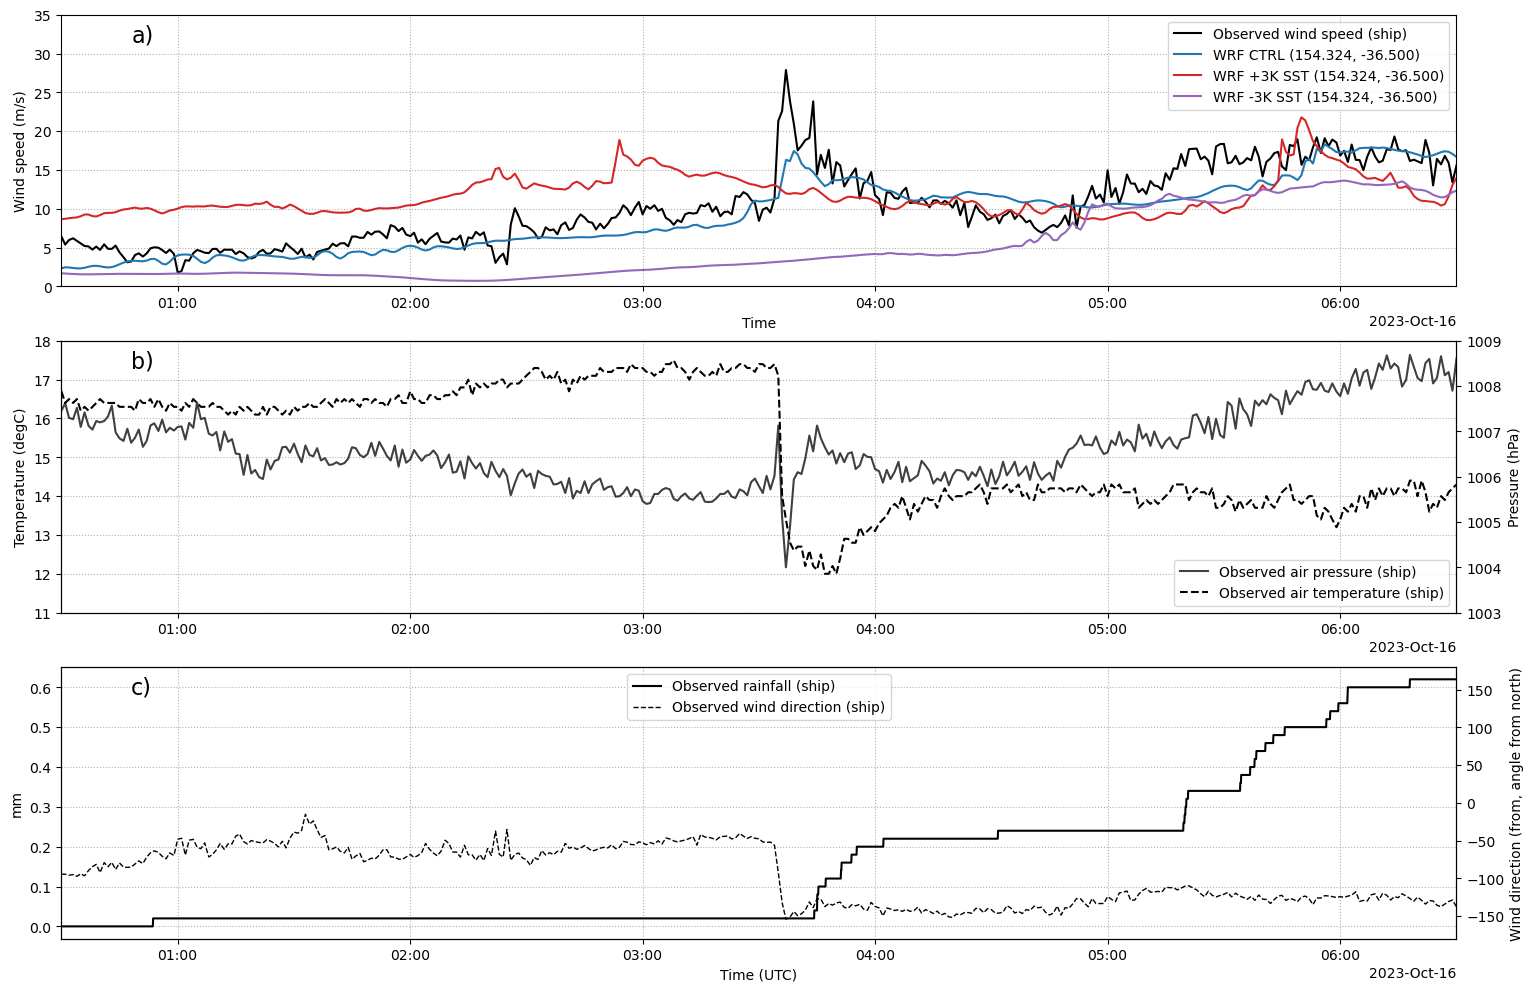

In [14]:
def plot_met_data(da_windspeed,
                  da_winddir,
                  da_airpressure,
                  da_dewpt,
                  da_airtemp,
                  da_rain,
                  t1,
                  t2,
                  ws_ax,
                  temp_ax,
                  rain_ax,
                  zero_to_360=True,title="",
                  pres_lim=None,temp_lim=None,speed_lim=None,sst=False,
                  fname_sst=[""],radiation=False,ccn=False,fname_ccn=[""],plot_lat=False,fname_lat=[""],vert_lines=False,
                 wrf_list = [], wrf_cols=[], wrf_labs=[]):
    

#    ax2 = ws_ax.twinx()
    ln_list=[da_windspeed.plot(label="Observed wind speed (ship)",ax=ws_ax,color="k")[0]]
    #ws_ax.axhline(da_windspeed.values.max(),color="k",ls="--")
    if zero_to_360:
        dir1 = da_winddir.values
        lims = [0,360]
    else:
        dir1 = (da_winddir.values + 180) % 360 - 180
        lims = [-180,180]
    ws_ax.grid(ls=":")
    ws_ax.set_title(title)
    ws_ax.set_ylim(speed_lim)
    ws_ax.set_xlabel("")
    if vert_lines:
        [ws_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]
    ws_ax.set_xlim([pd.to_datetime(t1),pd.to_datetime(t2)])
    
    if len(wrf_list)>0:
        for i in range(len(wrf_list)):
            ln=wrf_list[i].plot(label=wrf_labs[i],ax=ws_ax,color=wrf_cols[i])[0]
            ln_list.append(ln)
    ws_ax.set_ylabel("Wind speed (m/s)")            
            
        
    labs = [l.get_label() for l in ln_list]
    ws_ax.legend(ln_list, labs, loc="upper right")    
    ws_ax.text(0.05,0.9,"a)",size=16,transform=ws_ax.transAxes)
    
    ax2 = temp_ax.twinx()
    lns1=da_airpressure.plot(color="k",ls="-",label="Observed air pressure (ship)",ax=ax2,alpha=0.75)[0]
    #da_dewpt.plot(color="tab:blue",ls=":",label="Dewpoint temperature",ax=temp_ax)
    lns2=da_airtemp.plot(color="k",ls="--",label="Observed air temperature (ship)",ax=temp_ax)[0]
    

    lns = [lns1,lns2]
    labs = [l.get_label() for l in lns]
    temp_ax.legend(lns, labs, loc="lower right")
    temp_ax.grid(ls=":")
    temp_ax.set_ylim(temp_lim)
    ax2.set_ylim(pres_lim)
    temp_ax.set_ylabel("Temperature (degC)")
    ax2.set_ylabel("Pressure (hPa)")
    temp_ax.set_xlabel("")
    temp_ax.text(0.05,0.9,"b)",size=16,transform=temp_ax.transAxes)        

    if vert_lines:
        [temp_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]
    temp_ax.set_xlim([pd.to_datetime(t1),pd.to_datetime(t2)])

    lns1=da_rain.plot(ax=rain_ax,color="k",label="Observed rainfall (ship)")[0]
    rain_ax.set_ylabel("mm")
    rain_ax.set_xlabel("Time (UTC)")
    rain_ax.grid(ls=":")
    rain_ax.legend(loc=2)
    rain_ax.text(0.05,0.9,"c)",size=16,transform=rain_ax.transAxes)    
    
    ax2=rain_ax.twinx()
    lns2=ax2.plot(da_windspeed.time.values,dir1,color="k",lw=1,alpha=1,label="Observed wind direction (ship)",ls="--")[0]
    ax2.set_ylim(lims)    
    ax2.set_ylabel("Wind direction (from, angle from north)")
    
    lns = [lns1,lns2]
    labs = [l.get_label() for l in lns]
    rain_ax.legend(lns, labs, loc="upper center")
    

    if vert_lines:
        [rain_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]
    rain_ax.set_xlim([pd.to_datetime(t1),pd.to_datetime(t2)])

    if vert_lines:
        [rain_ax.axvline(pd.to_datetime(t),ls=":",color="k") for t in vert_lines]

#    plt.savefig("/Volumes/Voyages/current/science/radiosonde/figs/"+title+".jpeg",dpi=100,bbox_inches="tight")




title=""
pres_lim = [1003,1009]
speed_lim = [0,35]
temp_lim = [11,18]


plt.figure(figsize=[18,12])
plot_met_data(da_windspeed, da_winddir, da_airpressure, da_dewpt, da_airtemp, da_rain
    ,t1,t2,plt.subplot(3,1,1),plt.subplot(3,1,2),plt.subplot(3,1,3),zero_to_360=False,title=title,pres_lim=pres_lim,temp_lim=temp_lim,speed_lim=speed_lim,
             wrf_list=[wrf_ws,wrf_3Kplus_ws,wrf_3Kminus_ws],
              wrf_cols=["tab:blue","tab:red","tab:purple"],
              wrf_labs=["WRF CTRL (154.324, -36.500)","WRF +3K SST (154.324, -36.500)","WRF -3K SST (154.324, -36.500)"])

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/time_series.jpeg",dpi=500,bbox_inches="tight")

In [10]:
print("CTRL convective max: ",wrf_ws.sel(Time=slice("2023-10-16 02:00","2023-10-16 05:00")).values.max())
print("+3K convective max: ",wrf_3Kplus_ws.sel(Time=slice("2023-10-16 02:00","2023-10-16 05:00")).values.max())
print("-3K convective max: ",wrf_3Kminus_ws.sel(Time=slice("2023-10-16 02:00","2023-10-16 05:00")).values.max())

CTRL convective max:  17.440609
+3K convective max:  18.877789
-3K convective max:  10.688612


In [11]:
print("CTRL total max: ",wrf_ws.values.max())
print("+3K total max: ",wrf_3Kplus_ws.values.max())
print("-3K total max: ",wrf_3Kminus_ws.values.max())

CTRL total max:  18.313309
+3K total max:  21.785461
-3K total max:  13.640649
